# 2D Numerical anisotropy with finite difference approximation
_Computational Seismology, Igel (2016)_ <br>
Exercise 4.31

_Increase the dominant frequency of the wavefield in 2D. Investigate the behaviour of the wavefield as a function of azimuth. Why does the wavefield look anisotropic? Which direction is the most accurate and why?_


<strong>Numerical anisotropy</strong> is when the calculated wavefield becomes artificially anisotropic for high frequencies as a result of numerical approximation. In other words, certain directions in the wavefield become numerically dispersive faster.

<p style="width:500px;float:right;padding-left:25px">
<img src=4.31_num_aniso.png>
<span style="font-size:smaller">
</span>
</p>

<br>
<strong>Scenario: P-waves in reservoir  (p. 90)</strong><br>
"We want to simulate P-wave propagation in a reservoir scale model with maximum velocity $c_{max}$ = 5 km/s and minimum velocity $c_{min}$ = 3 km/s. The dominant frequency is chosen to be $f_0$ = 20 Hz (from the discussion of the source time function above we expect energy up to 50 Hz to be present in the waveforms). The dominant wavelength is $λ_0$ = $c/f_0$ = 150 m. For this exercise we simulate a spatial domain of 5 km × 5 km and use a grid point distance $dx$ = 10 m resulting in 15 grid points per wavelength for the dominant frequency. We examine the behaviour of the wavefield looking at the snapshots resulting from a source injected at the centre of the model."
 <br>
<br>
Note that the scalar acoustic wave equation is mathematically identical to the SH-wave-propagation problem (assuming constant density). So, in the case of fault-zone trapped waves that are predominantly observed for SH-type ground motions, this is a useful basic physical model." 
<br>
<br>
"While at 20 Hz an isotropic wave field can be observed, at higher frequencies (fewer points per wavelength) numerical dispersion appears first in the direction of the grid axes."
<br><br>
For higher frequencies, the azimuthal direction that is most accurate is at 45$\degree$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
operator = 5

xmax = 5                # spatial range (km)
zmax = 5
dx = .01                # distance between grid points (km)
dz = dx
nx = int(xmax/dx)       # number of grid points
nz = int(zmax/dz)
    
tmax = 1                # length of seismogram (s)
dt = .001               # time interval (s)
nt = int(tmax/dt)       # number of time steps
    
xsrc = 0
zsrc = 0                # z-coord. of source
xrec = 1                # x-coord. of receiver
zrec = 1.5              # z-coord. of source
c = 5                   # velocity
f0s = [20, 35, 50, 65]  # dominant frequencies (Hz)
t0 = .3                 # time shift (s)
tsnap = .5              # time snapshot is taken (s)

x = np.arange(-xmax/2, xmax/2, dx)   # space
z = np.arange(-zmax/2, zmax/2, dz)
t = np.arange(0, tmax, dt)           # time

# get indices of source & receiver locations (will be used to add source term/make seis in algorithm)
ixsrc, ixrec = round(((xsrc+xmax/2)/xmax)*len(x)), round(((xrec+xmax/2)/xmax)*len(x))
izsrc, izrec = round(((zsrc+zmax/2)/zmax)*len(z)), round(((zrec+zmax/2)/zmax)*len(z))

# get index of snapshot time (or closest to it):
itsnap = np.abs(t - tsnap).argmin()

# CFL criterion check
if operator == 3:
    eps = c*dt/dx
    if eps > 1:
        raise ValueError('Error: CFL criterion not satisfied! Ensure that c*dt/dx <= 1.')

if operator == 5:
    eps = c*dt/dx
    if eps > 1/np.sqrt(3):     # apparently, CFL condition is altered for higher operators
        raise ValueError('CFL criterion not satisfied! Ensure that c*dt/dx <= 1/sqrt(3).')


print('# grid points in x:', nx, '\n# grid points in z:', nz, '\n# grid points in time:', nt)


# grid points in x: 500 
# grid points in z: 500 
# grid points in time: 1000


#### Source time function

In [3]:
srcs = np.zeros((len(f0s), nt))

for i in range(len(f0s)):
    srcs[i] = -8*f0s[i]*(t-t0)*np.exp(  -((t - t0)*f0s[i])**2   )

#### Finite-difference calculations

In [4]:
p = np.zeros((nx, nz))
pold = np.zeros((nx, nz))   # p(t-dt)
pnew = np.zeros((nx, nz))   # p(d+dt)
dx2p = np.zeros((nx, nz))   # 2nd derivative in space
dz2p = np.zeros((nx, nz))   # 2nd derivative in space
seis = np.zeros(nt)
psnap = np.zeros((len(f0s), nx, nz))


for ifreq in range(len(f0s)):
    
    for it in range(nt):
    
        # calculate partial derivatives
        if operator == 3:
            for ix in range(1, nx - 1):
                dx2p[ix, :] = (p[ix + 1, :] - 2 * p[ix, :] + p[ix - 1, :]) / dx**2
                
            for iz in range(1, nz - 1):
                dz2p[:, iz] = (p[:, iz + 1] - 2 * p[:, iz] + p[:, iz - 1]) / dz**2
    
        if operator == 5:
            for ix in range(2, nx-2):
                dx2p[ix, :] = (4*(p[ix + 1, :] + p[ix - 1, :])/3  -  5*p[ix, :]/2      - (p[ix + 2, :] + p[ix - 2, :])/12) / (dx**2)
             
            for iz in range(2, nz - 2):
                dz2p[:, iz] = (4*(p[:, iz + 1] + p[:, iz - 1])/3  -  5*p[:, iz]/2   - (p[:, iz + 2] + p[:, iz - 2])/12) / (dz**2)
        
        # time extrapolation
        pnew = 2 * p - pold + c**2 * dt**2 * (dx2p + dz2p)
     
        # add source term at (ixsrc, izsrc)
        pnew[ixsrc, izsrc] = pnew[ixsrc, izsrc] + dt**2 * srcs[ifreq][it] / np.sqrt(dx**2 + dz**2)
    
        # remap time levels
        pold = p
        p = pnew
    
        if it == itsnap:
            psnap[ifreq] = p
        
        # make seismogram
        seis[it] = p[ixrec, izrec]

#### Numerical anisotropy

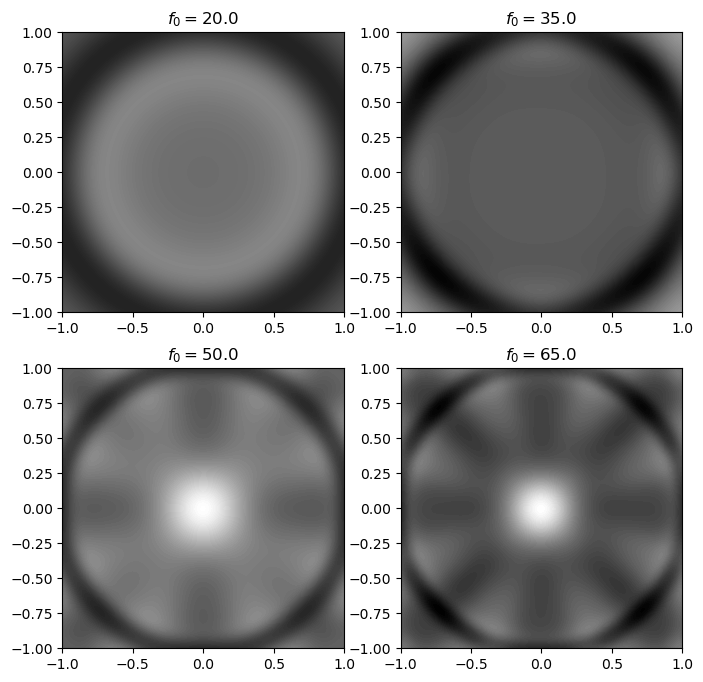

In [5]:
X, Z = np.meshgrid(x, z)
fig_s, axs = plt.subplots(2,2, figsize = (8,8))
axs = axs.flatten()

# Make snapshots for a range of dominant frequencies
for i in range(len(f0s)):
    snap = axs[i].contourf(X, Z, psnap[i], levels = 70, vmin = np.min(psnap), vmax = np.max(psnap), cmap = 'gist_yarg')
    axs[i].set_title('$f_0 = {:.1f}$'.format(f0s[i]))
    axs[i].set_xlim(-1,1)
    axs[i].set_ylim(-1,1)